# Spam Detection - Classification

![image](https://storage.googleapis.com/kaggle-datasets-images/483/982/15b24a8964e8d4afadff79a1a5543450/dataset-cover.jpg)

This project aims to perform the SMS spam classification task using the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).



## Project Navigation

* [1. Required Libraries](#1)
* [2. Checking the target variable](#2)
* [3. Data pre-processing](#3)
* [4. SMS Spam Classification](#4)

<a id="1"></a>
## 1. Required Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import charset_normalizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(99)
random.seed(99)

In [2]:
# attempting to detect the csv file character encoding
with open("spam.csv", "rb") as csv:
    detected_encoding = charset_normalizer.detect(csv.read(250000))
    print(f"Detected encoding {detected_encoding['encoding']} with confidence level of {detected_encoding['confidence']}")

df = pd.read_csv("spam.csv", encoding=detected_encoding["encoding"])
df = df.loc[:,["v1", "v2"]]
df.info()

Detected encoding Windows-1252 with confidence level of 0.9988
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<a id="2"></a>
## 2. Checking the target variable

Let's look into the target variable frequency distribution.

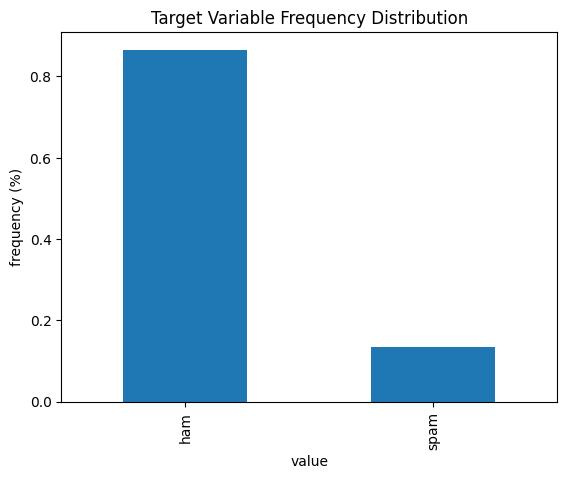

In [3]:
df["v1"].value_counts(normalize=True).plot(
    title="Target Variable Frequency Distribution",
    kind="bar",
    xlabel="value",
    ylabel="frequency (%)"
)
plt.show()

From the graph, we see that our data is highly unbalanced.

<a id="3"></a>
## 3. Data pre-processing

Let's encode the target variable values with 0s for hams and 1s for spams.

In [4]:
df["target"] = df["v1"].map(lambda x : 1 if x == "spam" else 0)

<a id="4"></a>
## 4. SMS Spam Classification

For the SMS Spam Classification task, we will use some of the state-of-the-art sentence embeddings techniques.
Sentence embedding is a collection of techniques in natural language processing where sentences are mapped into an intermediate representation (vectors of real numbers).
The embeddings (vectors) are used as inputs for the machine learning and deep learning models.

<a id="4_1_"></a>
### 4.1. Creating Sentence Embeddings

In [5]:
transformer = SentenceTransformer("all-mpnet-base-v2")
embeddings = transformer.encode(df["v2"], show_progress_bar=True)
print(embeddings.shape)

Batches:   0%|          | 0/175 [00:00<?, ?it/s]

(5572, 768)


<a id="4_2_"></a>
### 4.2. Visualizing

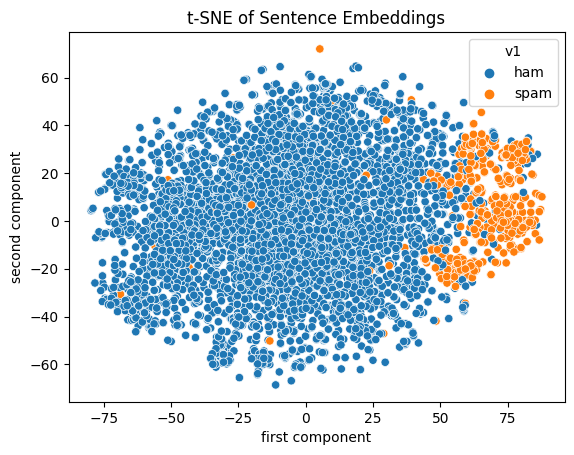

In [6]:
tsne = TSNE()
converted = tsne.fit_transform(embeddings)
plt.title("t-SNE of Sentence Embeddings")
sns.scatterplot(x=converted[:,0], y=converted[:,1], hue=df["v1"])
plt.xlabel("first component")
plt.ylabel("second component")
plt.show()

It seems that the sentence transformer did a great job creating the embeddings. We can see two clear clusters of data, for spams and hams.

<a id="4_3_"></a>
### 4.3. Splitting Data: Train/Test

In [7]:
y = df["target"].values
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=.2, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (4457, 768)
X_test: (1115, 768)


<a id="4_4_"></a>
### 4.4. Base Classifier - LogisticRegression

We will use the LogisticRegression classifier as the base model for this project.

In [8]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
auc = np.round(roc_auc_score(y_test, y_pred), 3)
print(f"ROC AUC: {auc}")

ROC AUC: 0.937
